In [333]:
# Pennylane
import pennylane as qml
from pennylane import numpy as np
from scipy.linalg import expm
# Plotting
import matplotlib.pyplot as plt

# Setting of the main hyper-parameters of the model

In [682]:
n_qubits = 3  # Number of system qubits.
n_shots = 10 ** 6  # Number of quantum measurements.

# Hyper-parameters for the HHL algorithm
phase_qubits = 4 # Number of qubits used for phase estimation.
ancilla_qubit = 1 # Number of ancillary qubits used for eigenvalue encoding amplitude
tot_qubits_HHL = n_qubits + phase_qubits + ancilla_qubit # Total number of qubits (system + ancillary + QPE qubits).

# Hybrid algorithm hyper-parameters
ancilla_idx = n_qubits  # Index of the one ancillary qubit (last position).
tot_qubits_VQLS = n_qubits + 1  # Total number of qubits (system + ancillary).
steps = 50  # Number of optimization steps
eta = 0.8  # Learning rate
rng_seed = 0  # Seed for random number generator
dim = 2 ** n_qubits  # Dimension of the problem space
epsilon = 1e-6  # threshold for convergence

In [683]:
# For the HHL algorithm, we need to define the phase estimation wires and target wires.
# Assume phase_wires and target_wire are defined as in previous cells
phase_wires = range(phase_qubits)  # Phase estimation wires
target_wires = range(phase_qubits, phase_qubits + n_qubits)  # Target wires
ancilla_wires = range(phase_qubits + n_qubits, phase_qubits + n_qubits + ancilla_qubit)  # Ancilla wires

In [558]:
# Specified power injections (Sbus)
# Bus 1: Slack → value not used for mismatch (can set to 0)
# Bus 2: PQ bus with P=10 MW, Q=0
# Bus 3: PQ bus with P=-15 MW, Q=-5 MVAr
Sbus = [0+0j, 0.1+0j, -0.15-0.05j]

# Ybus matrix for 3-bus system (from the paper's example)
Ybus = np.array([
    [0 - 2j, 0 + 1j, 0 + 1j],
    [0 + 1j, 0 - 1.5j, 0 + 0.5j],
    [0 + 1j, 0 + 0.5j, 0 - 1.5j]
])

In [ ]:
# Three buses system
B_prime = np.array([[-1.5, 0.5],
           [0.5, -1.5]], dtype=np.complex128)

B_double_prime = np.array([[-1.5, 0.5],
                  [0.5, -1.5]], dtype=np.complex128)
# These matrix need to be redefiend to be a positive deifined matrix

In [ ]:
# Five buses system
B_double_prime = np.array([
    [1, 0, 0, 1],
    [0, 2, 1, 0],
    [0, 1, 3, 0],
    [1, 0, 0, 4]
], dtype=complex)

In [ ]:
# Nine buses system
B_double_prime = A = np.array([
    [ 4, -1,  0,  0, -1,  0,  0,  0],
    [-1,  4, -1,  0,  0, -1,  0,  0],
    [ 0, -1,  4, -1,  0,  0, -1,  0],
    [ 0,  0, -1,  4,  0,  0,  0, -1],
    [-1,  0,  0,  0,  4, -1,  0,  0],
    [ 0, -1,  0,  0, -1,  4, -1,  0],
    [ 0,  0, -1,  0,  0, -1,  4, -1],
    [ 0,  0,  0, -1,  0,  0, -1,  4],
],dtype=complex)

# HHL algorithm

In [585]:
def apply_unitary(A_matrix,wires):
    # Compute the unitary U = exp(iA)
    U = expm(1j * A_matrix)
    # Apply the unitary operation to the specified wires
    qml.QubitUnitary(U, wires=wires)

# Define the quantum phase estimation circuit
def qpe_circuit(A_matrix, phase_wires, target_wire): 
    # Initialize target in eigenstate of U
    # qml.Hadamard(wires=target_wire)

    # Apply Hadamards to phase register
    for w in phase_wires:
        qml.Hadamard(wires=w)

    # Apply controlled-U^{2^k}
    apply_unitary_powers = [2 ** i for i in range(len(phase_wires))]

    for i, power in enumerate(apply_unitary_powers):
        for _ in range(power):
            qml.ctrl(apply_unitary, control=phase_wires[::-1][i])(A_matrix = A_matrix,wires=target_wire)

    # Apply inverse QFT
    qml.adjoint(qml.QFT)(wires=phase_wires)

# Define the controlled fractional rotation operation
def AQE_fractional_rotation(control_wires, target_wire):
    """Apply controlled RY rotation based on fractional binary interpretation of control qubits."""
    n = len(control_wires)

    for d in range(1, 2**n):  # skip d=0 to avoid divide-by-zero
        # Convert decimal to binary string to run all possible state
        bin_str = f"{d:0{n}b}"
        # Convert binary string to list of bits for controlled rotation
        bit_strings = [int(bit) for bit in bin_str]
        # Compute fractional binary value: d = sum x_j * 2^-j
        fractional_d = sum(int(bit) * 2**-(j+1) for j, bit in enumerate(bin_str))
        # Compute the inverse of the fractional value
        inv = 1 / fractional_d
        # Normalize to [0, 1] range
        inv = inv / (2 ** n)
        # Convert to angle for RY gate, the state |0> amplitude corresponds to inv value
        theta = np.arccos(inv) * 2  # 2*theta for full RY
        # Apply controlled RY rotation on target wire controling on control wires
        qml.ctrl(qml.RY, control=control_wires, control_values=bit_strings)(theta,wires=target_wire)

In [735]:
hhl_al(B_double_prime,Init_vector)

tensor([0.0853112, 0.1646888, 0.1646888, 0.0853112, 0.0853112, 0.1646888,
        0.1646888, 0.0853112], requires_grad=True)

In [733]:
dev = qml.device("default.qubit", wires=tot_qubits_HHL)
@qml.qnode(dev)
def hhl_circuit(A_matrix,vector):
    # 1. Initialize the target qubit
    # Normalize the input vector
    norm_vector = vector / np.linalg.norm(vector)
    # Initialize the quantum state to the normalized vector on the target wires
    qml.QubitStateVector(norm_vector, wires=target_wires)
    # for target_wire in target_wires:
    #     qml.Hadamard(wires=target_wire) # in this example, |b> = U_b |0> = H_0 H_1 ... |0>

    # 2. Apply QPE (Quantum Phase Estimation)
    qpe_circuit(A_matrix, phase_wires, target_wires)

    # 3. Apply AQE fractional rotation (controlled RY based on phase_wires)
    AQE_fractional_rotation(phase_wires, ancilla_wires)

    # 4. Apply inverse QPE (adjoint of QPE)
    qml.adjoint(qpe_circuit)(A_matrix, phase_wires, target_wires)

    # 5. Measure the target qubit
    probs = qml.probs(wires= [*target_wires,*ancilla_wires])
    return probs

def hhl_al(A_matrix, vector):
    probs = hhl_circuit(A_matrix, vector)
    #6. Get indices where ancilla qubit is 0 (i.e., even indices)
    ancil_position = tot_qubits_HHL - ancilla_wires[0] - 1  # Assuming ancilla_wires is a list with one element
    ancilla_zero_indices = [i for i in range(len(probs)) if (i & 2**ancil_position) == 0]
    # Filter probabilities where ancilla qubit is in |0>
    probs_ancilla0 = probs[ancilla_zero_indices]
    # Normalize the filtered probabilities ???
    probs_ancilla0_normalized = probs_ancilla0 / np.sum(probs_ancilla0) # * np.linalg.norm(vector)**2  
    
    return probs_ancilla0_normalized

# Variational quantum linear solver

In [707]:
def U_b(vector):
    """Unitary matrix rotating the ground state to the problem vector |b> = U_b |0>."""
    # Normalize the input vector
    # norm_vector = vector / np.linalg.norm(vector)
    # Initialize the quantum state to the normalized vector on the target wires
    # qml.QubitStateVector(norm_vector, wires=[i for i in range(n_qubits)])
    for idx in range(n_qubits):
        qml.Hadamard(wires=idx)

def CA_gate(idx, ancilla_idx, hamiltonian):
    """Controlled versions of the unitary components A_idx of the problem matrix A."""
    if n_qubits == 1:
        if hamiltonian.ops[idx].name == 'Identity':
            return  # Idientity operation, do nothing
        elif hamiltonian.ops[idx].name == 'PauliX':
            qml.CNOT(wires=[ancilla_idx, 0]) # Apply X gate 
        elif hamiltonian.ops[idx].name == 'PauliZ':
            qml.CZ(wires=[ancilla_idx, 0]) # Apply Z gate
        elif hamiltonian.ops[idx].name == 'PauliY':
            qml.CY(wires=[ancilla_idx, 0]) # Apply Y gate
    else:
        for i in range(n_qubits):
            if hamiltonian.ops[idx][i].name == 'Identity':
                continue    # Idientity operation, do nothing
            elif hamiltonian.ops[idx][i].name == 'PauliX':
                qml.CNOT(wires=[ancilla_idx, i]) # Apply X gate 
            elif hamiltonian.ops[idx][i].name == 'PauliZ':
                qml.CZ(wires=[ancilla_idx, i]) # Apply Z gate
            elif hamiltonian.ops[idx][i].name == 'PauliY':
                qml.CY(wires=[ancilla_idx, i]) # Apply Y gate


In [708]:
def variational_block(weights):
    '''Variational block for the real amplitude ansatz, applying RY rotations and CNOTs in a linear entanglement pattern.'''
    depth = len(weights) // n_qubits

    param_index = 0
    for _ in range(depth):
        # Step 1: Apply RY rotations
        for i in range(n_qubits):
            qml.RY(weights[param_index], wires=i)
            param_index += 1

        # Step 2: Apply entangling CNOTs (linear)
        for i in range(n_qubits - 1):
            qml.CNOT(wires=[i, i+1])

In [709]:
dev_mu = qml.device("default.qubit", wires= tot_qubits_VQLS)
@qml.qnode(dev_mu, interface="autograd")
def local_hadamard_test(weights, l=None, lp=None, j=None, part=None):
    """Local Hadamard test for estimating the expectation value of a Hermitian operator."""
    # First Hadamard gate applied to the ancillary qubit.
    qml.Hadamard(wires=ancilla_idx)

    # For estimating the imaginary part of the coefficient "lambda", we must add a "-i"
    # phase gate.
    if part == "Im" or part == "im":
        qml.PhaseShift(-np.pi / 2, wires=ancilla_idx)

    # Variational circuit generating a guess for the solution vector |x>
    variational_block(weights)

    # Controlled application of the unitary component A_l of the problem matrix A.
    # CA(l) # Manual defined operators for specific A
    CA_gate(l, ancilla_idx, hamiltonian) # Generalized operators for a Hermitian A

    # Adjoint of the unitary U_b associated to the problem vector |b>.
    U_b(Init_vector) # In this specific example Adjoint(U_b) = U_b.

    # Controlled Z operator at position j. If j = -1, apply the identity.
    if j != -1:
        qml.CZ(wires=[ancilla_idx, j])

    # Unitary U_b associated to the problem vector |b>.
    U_b(Init_vector)

    # Controlled application of Adjoint(A_lp).
    # In this specific example Adjoint(A_lp) = A_lp.
    # CA(lp) # Manual defined operators for specific A
    CA_gate(lp, ancilla_idx, hamiltonian) # Generalized operators for a Hermitian A
    
    # Second Hadamard gate applied to the ancillary qubit.
    qml.Hadamard(wires=ancilla_idx)

    # Expectation value of Z for the ancillary qubit.
    return qml.expval(qml.PauliZ(wires=ancilla_idx))

def mu(weights, l=None, lp=None, j=None):
    """Generates the coefficients to compute the "local" cost function C_L."""

    mu_real = local_hadamard_test(weights, l=l, lp=lp, j=j, part="Re")
    mu_imag = local_hadamard_test(weights, l=l, lp=lp, j=j, part="Im")

    return mu_real + 1.0j * mu_imag

def psi_norm(weights):
    """Returns the normalization constant <psi|psi>, where |psi> = A |x>."""
    norm = 0.0

    for l in range(0, len(coupling)):
        for lp in range(0, len(coupling)):
            norm = norm + coupling[l] * np.conj(coupling[lp]) * mu(weights, l, lp, -1)

    return abs(norm)

def cost_loc(weights):
    """Local version of the cost function. Tends to zero when A|x> is proportional to |b>."""
    mu_sum = 0.0
    
    for l in range(0, len(coupling)):
        for lp in range(0, len(coupling)):
            for j in range(0, n_qubits):
                mu_sum = mu_sum + coupling[l] * np.conj(coupling[lp]) * mu(weights, l, lp, j)

    mu_sum = abs(mu_sum)

    # Cost function C_L
    return 0.5 - 0.5 * mu_sum / (n_qubits * psi_norm(weights))

In [679]:
# 2) Use qml.specs to get resource info
specs_fn = qml.specs(local_hadamard_test)
info = specs_fn(w,1,1,1)

# 3) Extract what you need
gate_counts = info["resources"].gate_types
depth       = info["resources"].depth
num_wires   = info["resources"].num_wires

# 4) Display results
print("Gate counts:")
for gate, count in gate_counts.items():
    print(f"  {gate:>4s} : {count}")

print(f"\nCircuit depth    : {depth}")
print(f"Number of wires  : {num_wires}")

Gate counts:
  Hadamard : 6
    RY : 4
  CNOT : 2
    CZ : 3

Circuit depth    : 10
Number of wires  : 3


In [710]:
def VQLS(init_weights, steps=steps, eta=eta):
    """Variational Quantum Linear Solver (VQLS) algorithm."""
    # Set the random seed
    np.random.seed(rng_seed)
    # Define the optimizer
    opt = qml.GradientDescentOptimizer(eta)
    # Variational optimization loop
    cost_history = []
    w = init_weights
    for it in range(steps):
        if cost_loc(w) > epsilon:  # Continue until cost is sufficiently low
            w, cost = opt.step_and_cost(cost_loc, w)
            print("Step {:3d}       Cost_L = {:9.7f}".format(it, cost))
            cost_history.append(cost)
        else:
            break
    return w, cost_history

# Comparing Linear Solver Methods

## VQSL running

In [711]:
# Example: 2-qubit Hermitian matrix
A = B_double_prime
Init_vector = np.ones(dim) / np.sqrt(dim) # Vector Initial state |b>
# Ensure it's Hermitian
assert np.allclose(A, A.conj().T)
# Decompose the Hermitian matrix into Pauli operators
hamiltonian = qml.pauli_decompose(A)
# Coefficients of the linear combination A = c_0 A_0 + c_1 A_1 ...
coupling = hamiltonian.coeffs
layers_ansatz = 2  # Number of layers in the ansatz
# Initialize the quantum weights
init_weights = 0.01 * np.random.randn(n_qubits * layers_ansatz, requires_grad=True)

In [712]:
# Prepare a new quantum device for sampling define the associated qnode circuit
dev_x = qml.device("default.qubit", wires=tot_qubits_VQLS)

@qml.qnode(dev_x, interface="autograd")
def prepare_and_sample(weights):

    # Variational circuit generating a guess for the solution vector |x>
    variational_block(weights)

    # We assume that the system is measured in the computational basis.
    # then sampling the device will give us a value of 0 or 1 for each qubit (n_qubits)
    # this will be repeated for the total number of shots provided (n_shots)
    return qml.probs(wires=range(n_qubits)) 
    # return qml.sample() 

In [713]:
# Set the random seed
np.random.seed(rng_seed)
# Define the optimizer
opt = qml.GradientDescentOptimizer(eta)
# Initialize parameter
w = init_weights
# Variational optimization loop
cost_history = []
coupling_VQLS = []
for it in range(steps):
    if cost_loc(w) > 1e-6:
        w, cost = opt.step_and_cost(cost_loc, w)
        print("Step {:3d}       Cost_L = {:9.7f}".format(it, cost))
        if cost_loc(w) > 0:
            coupling_VQLS.append(w)    
            cost_history.append(cost)
    else:
        break

Step   0       Cost_L = 0.3527622
Step   1       Cost_L = 0.3089504
Step   2       Cost_L = 0.2656346
Step   3       Cost_L = 0.2230837
Step   4       Cost_L = 0.1831131
Step   5       Cost_L = 0.1479251
Step   6       Cost_L = 0.1187617
Step   7       Cost_L = 0.0955823
Step   8       Cost_L = 0.0775785
Step   9       Cost_L = 0.0637334
Step  10       Cost_L = 0.0531090
Step  11       Cost_L = 0.0449337
Step  12       Cost_L = 0.0386025
Step  13       Cost_L = 0.0336526
Step  14       Cost_L = 0.0297341
Step  15       Cost_L = 0.0265854
Step  16       Cost_L = 0.0240123
Step  17       Cost_L = 0.0218716
Step  18       Cost_L = 0.0200580
Step  19       Cost_L = 0.0184946
Step  20       Cost_L = 0.0171252
Step  21       Cost_L = 0.0159087
Step  22       Cost_L = 0.0148150
Step  23       Cost_L = 0.0138219
Step  24       Cost_L = 0.0129129
Step  25       Cost_L = 0.0120757
Step  26       Cost_L = 0.0113010
Step  27       Cost_L = 0.0105814
Step  28       Cost_L = 0.0099112
Step  29      

In [714]:
# w, cost_history = VQLS(init_weights, steps=steps, eta=eta)
# Generate the quantum state |x> and sample it
# Using the variational weights w that we have previously optimized.
probs_VQLS = prepare_and_sample(coupling_VQLS[-1])
print("Quantum probabilities for VQLS:", probs_VQLS)

Quantum probabilities for VQLS: [0.11944558 0.17083993 0.17487389 0.0697394  0.0742229  0.18927007
 0.11786232 0.08374591]


<!-- ## HHL running -->

## HHL running

In [736]:
B_double_prime_HHL = -np.array(B_double_prime)

In [737]:
probs_HHL = hhl_al(B_double_prime, Init_vector)
print("Quantum probabilities from HHL:", probs_HHL)

Quantum probabilities from HHL: [0.0853112 0.1646888 0.1646888 0.0853112 0.0853112 0.1646888 0.1646888
 0.0853112]


## Classical running

In [715]:
probs_cl = CLS(B_double_prime, Init_vector)
# In order to compare x with the quantum state |x>, we normalize and square its elements.
probs_cl = (probs_cl / np.linalg.norm(probs_cl)) ** 2
print("Classical probabilities:", probs_cl)

Classical probabilities: [0.09+0.j 0.16+0.j 0.16+0.j 0.09+0.j 0.09+0.j 0.16+0.j 0.16+0.j 0.09+0.j]


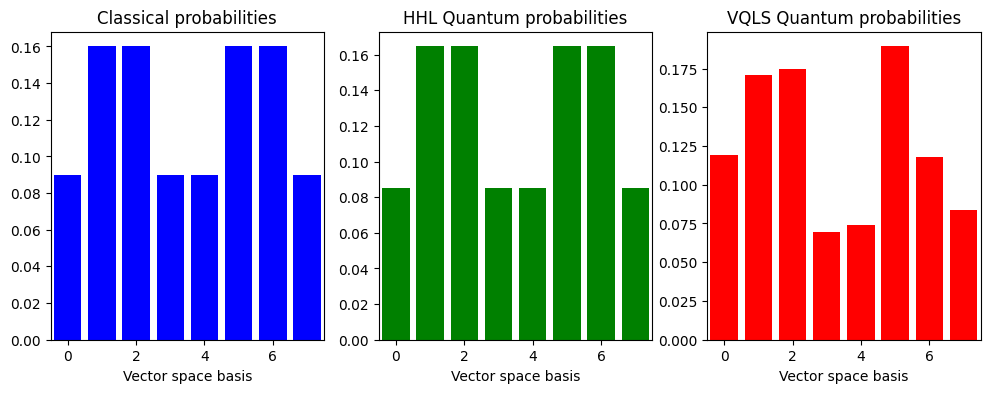

In [740]:
# Graphically visualize both distributions.
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

ax1.bar(np.arange(0, 2 ** n_qubits), probs_cl, color="blue")
ax1.set_xlim(-0.5, 2 ** n_qubits - 0.5)
ax1.set_xlabel("Vector space basis")
ax1.set_title("Classical probabilities")

ax2.bar(np.arange(0, 2 ** n_qubits), probs_HHL, color="green")
ax2.set_xlim(-0.5, 2 ** n_qubits - 0.5)
ax2.set_xlabel("Vector space basis")
ax2.set_title("HHL Quantum probabilities")

ax3.bar(np.arange(0, 2 ** n_qubits), probs_VQLS, color="red")
ax3.set_xlim(-0.5, 2 ** n_qubits - 0.5)
ax3.set_xlabel("Vector space basis")
ax3.set_title("VQLS Quantum probabilities")

plt.show()

Checking the similarity between two distribution by Relative Entropy

In [ ]:
from scipy.special import rel_entr

def kl_divergence(P, Q):
    """
    Compute the Kullback-Leibler divergence D_KL(P || Q) between two discrete probability distributions.

    Parameters:
    - P: array-like, true or observed probability distribution
    - Q: array-like, reference or model probability distribution

    Returns:
    - KL divergence (float)
    """
    P = np.asarray(P, dtype=np.float64)
    Q = np.asarray(Q, dtype=np.float64)

    # Normalize if not already
    P /= P.sum()
    Q /= Q.sum()

    if np.any((P > 0) & (Q == 0)):
        raise ValueError("KL divergence is undefined: Q has zero where P is non-zero.")

    return np.sum(rel_entr(P, Q))


In [742]:
result_VQLS = kl_divergence(probs_cl, probs_VQLS)
result_HHL = kl_divergence(probs_cl, probs_HHL)
print('Similarity between two distributions classical and VQLS:',result_VQLS)
print('Similarity between two distributions classical and HHL:',result_HHL)

Similarity between two distributions classical and VQLS: 0.018621475031920756
Similarity between two distributions classical and HHL: 0.0007757708081199176
